In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances

#### Import train and test json files as dataframes

In [2]:
train_df  = pd.read_json(open("train.json", "r"))
test_df = pd.read_json(open("test.json", "r"))
#print(train_df)

#### Exploratory data analysis

In [3]:
train_df.describe()
test_df.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,74659.000000,74659.000000,74659.000000,7.465900e+04,74659.000000,7.465900e+04
mean,1.212915,1.544663,40.735060,7.024001e+06,-73.945282,3.749033e+03
std,0.649820,1.107014,0.806687,1.264496e+05,1.487795,9.713092e+03
min,0.000000,0.000000,0.000000,6.811958e+06,-121.488000,1.000000e+00
25%,1.000000,1.000000,40.727800,6.915516e+06,-73.991800,2.495000e+03
50%,1.000000,1.000000,40.751600,7.021738e+06,-73.977700,3.150000e+03
75%,1.000000,2.000000,40.774300,7.129166e+06,-73.954700,4.100000e+03
max,112.000000,7.000000,42.872700,7.761779e+06,0.000000,1.675000e+06


#### target variable exploration

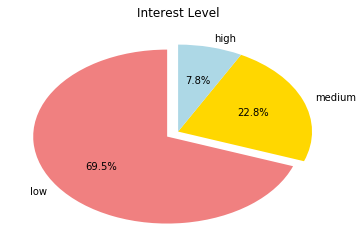

In [4]:
# Interest_level
labels = ["low","medium","high"]
sizes = train_df.interest_level.value_counts().values
explode=[0.1,0,0]
colors = ['lightcoral','gold','lightblue']
patches, texts,autotexts= plt.pie(sizes, labels=labels,colors=colors,explode=explode,autopct="%1.1f%%",
                        startangle=90)
plt.title("Interest Level")
plt.show()

#### imbalance data
- low: 69.5%
- medium: 22.8%
- high: 7.8%

#### map : interest_level
#### Seaborn style

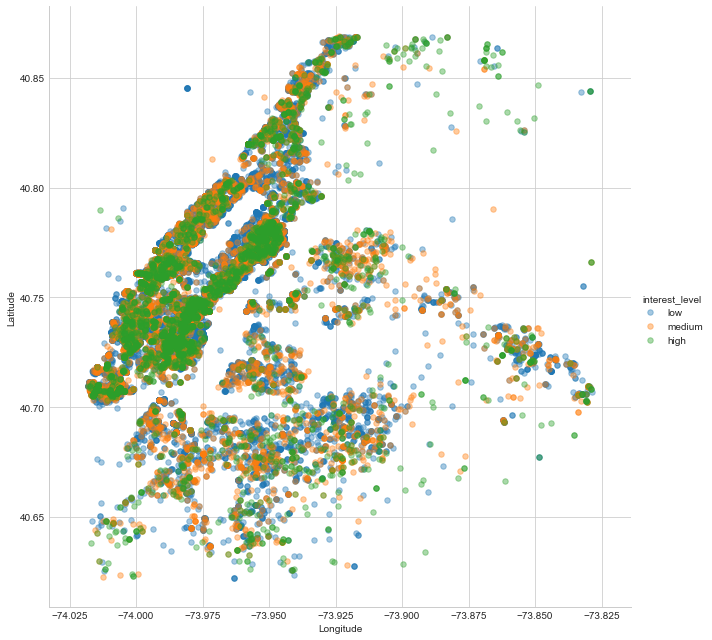

In [5]:
sns.set_style("whitegrid")

# Rent interest graph of New-York
sns.lmplot(x="longitude", y="latitude", fit_reg=False, hue='interest_level',
           hue_order=['low', 'medium', 'high'], size=9, scatter_kws={'alpha':0.4,'s':30},
           data=train_df[(train_df.longitude>train_df.longitude.quantile(0.005))
                           &(train_df.longitude<train_df.longitude.quantile(0.995))
                           &(train_df.latitude>train_df.latitude.quantile(0.005))                           
                           &(train_df.latitude<train_df.latitude.quantile(0.995))]);
plt.xlabel('Longitude');
plt.ylabel('Latitude');
plt.show()

#### Price exploration

In [6]:
fig = plt.figure(figsize=(12,12))

#### Price distribution

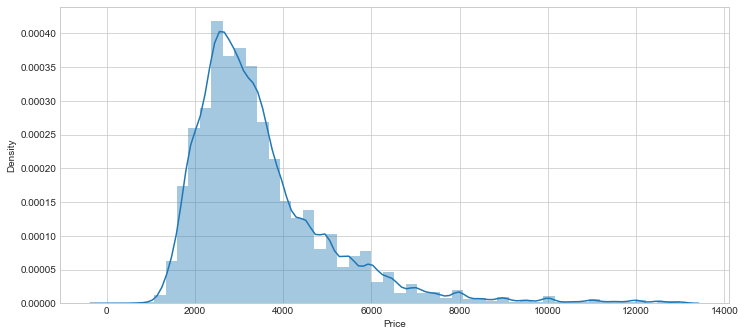

In [7]:
sns.distplot(train_df.price[train_df.price<=train_df.price.quantile(0.99)], ax=plt.subplot(211));
plt.xlabel('Price');
plt.ylabel('Density');
plt.show()

#### Average Price per Interest Level

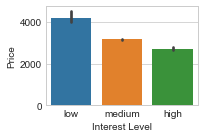

In [8]:
sns.barplot(x="interest_level", y="price", order=['low', 'medium', 'high'],
            data=train_df, ax=plt.subplot(223));
plt.xlabel('Interest Level');
plt.ylabel('Price');
plt.show()

#### Violinplot of price for every Interest Level

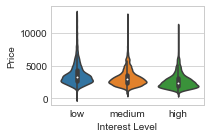

In [9]:
sns.violinplot(x="interest_level", y="price", order=['low', 'medium', 'high'],
               data=train_df[train_df.price<=train_df.price.quantile(0.99)],
               ax=plt.subplot(224));
plt.xlabel('Interest Level');
plt.ylabel('Price');   
plt.show()

#### Data Preparation

In [10]:
test_df["bathrooms"].loc[19671] = 1.5
test_df["bathrooms"].loc[22977] = 2.0
test_df["bathrooms"].loc[63719] = 2.0

#### See the frequency of each feature and rank them based on frequency

In [11]:
import collections
def most_common(lst):
    features = collections.Counter(lst)
    feature_value = features.keys()
    frequency = features.values()
    data = [('feature_value', feature_value),
            ('frequency', frequency),]    
    df = pd.DataFrame.from_items(data)
    return df.sort_values(by = 'frequency', ascending = False)

In [12]:
#Function to make a new column for features
def newColumn(name, df, series):
    feature = pd.Series(0, df.index, name = name)
    for row,word in enumerate(series):
        if name in word:
            feature.iloc[row] = 1
    df[name] = feature
    return df

#### Select features based on frequency
#### create dummy variables

In [13]:
facilities = ['Elevator','Cats Allowed','Hardwood Floors','Dogs Allowed','Doorman','Dishwasher','No Fee','Laundry in Building','Fitness Center',
             'Pre-War', 'Laundry in Unit', 'Roof Deck', 'Outdoor Space', 'Dining Room', 'High Speed Internet', 'Balcony', 'Swimming Pool']
for name in facilities:
    train_df = newColumn(name, train_df, train_df['features'])
    test_df = newColumn(name, test_df, test_df['features'])
print(train_df.head())

        bathrooms  bedrooms                       building_id  \
10            1.5         3  53a5b119ba8f7b61d4e010512e0dfc85   
10000         1.0         2  c5c8a357cba207596b04d1afd1e4f130   
100004        1.0         1  c3ba40552e2120b0acfc3cb5730bb2aa   
100007        1.0         1  28d9ad350afeaab8027513a3e52ac8d5   
100013        1.0         4                                 0   

                    created  \
10      2016-06-24 07:54:24   
10000   2016-06-12 12:19:27   
100004  2016-04-17 03:26:41   
100007  2016-04-18 02:22:02   
100013  2016-04-28 01:32:41   

                                              description  \
10      A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...   
10000                                                       
100004  Top Top West Village location, beautiful Pre-w...   
100007  Building Amenities - Garage - Garden - fitness...   
100013  Beautifully renovated 3 bedroom flex 4 bedroom...   

            display_address  \
10      Metropolitan Ave

#### Make attributes from created and photos column

In [14]:
train_df["created"] = pd.to_datetime(train_df["created"])
train_df["created_year"] = train_df["created"].dt.year
train_df["created_month"] = train_df["created"].dt.month
train_df["created_day"] = train_df["created"].dt.day
train_df["num_photos"] = train_df["photos"].apply(len)

In [15]:
#Test dataset
test_df["created"] = pd.to_datetime(test_df["created"])
test_df["created_year"] = test_df["created"].dt.year
test_df["created_month"] = test_df["created"].dt.month
test_df["created_day"] = test_df["created"].dt.day
test_df["num_photos"] = test_df["photos"].apply(len)


#### Create new attributes from price

In [16]:
train_df['price'] = train_df['price'].clip(upper=13000)
train_df["logprice"] = np.log(train_df["price"])
train_df["price_t"] =train_df["price"]/train_df["bedrooms"]
train_df["room_sum"] = train_df["bedrooms"]+train_df["bathrooms"]
train_df['price_per_room'] = train_df['price']/train_df['room_sum']

In [17]:
#Test dataset
test_df['price'] = test_df['price'].clip(upper=13000)
test_df["logprice"] = np.log(test_df["price"])
test_df["price_t"] =test_df["price"]/test_df["bedrooms"]
test_df["room_sum"] = test_df["bedrooms"]+test_df["bathrooms"]
test_df['price_per_room'] = test_df['price']/test_df['room_sum']

In [18]:
print(train_df.head())

        bathrooms  bedrooms                       building_id  \
10            1.5         3  53a5b119ba8f7b61d4e010512e0dfc85   
10000         1.0         2  c5c8a357cba207596b04d1afd1e4f130   
100004        1.0         1  c3ba40552e2120b0acfc3cb5730bb2aa   
100007        1.0         1  28d9ad350afeaab8027513a3e52ac8d5   
100013        1.0         4                                 0   

                   created                                        description  \
10     2016-06-24 07:54:24  A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...   
10000  2016-06-12 12:19:27                                                      
100004 2016-04-17 03:26:41  Top Top West Village location, beautiful Pre-w...   
100007 2016-04-18 02:22:02  Building Amenities - Garage - Garden - fitness...   
100013 2016-04-28 01:32:41  Beautifully renovated 3 bedroom flex 4 bedroom...   

            display_address  \
10      Metropolitan Avenue   
10000       Columbus Avenue   
100004          W 13 Street  

#### Create index for unique building and manager ids, then merge with train and test set

In [19]:
b_id = pd.concat([train_df['building_id'], test_df['building_id']]).unique()
b_id = pd.DataFrame(b_id)
b_id.columns = ['building_id']
b_id['building_index'] = [i for i in range(len(b_id))]
m_id = pd.concat([train_df['manager_id'], test_df['manager_id']]).unique()
m_id = pd.DataFrame(m_id)
m_id.columns = ['manager_id']
m_id['manager_index'] = [i for i in range(len(m_id))]
#print(m_id)
train_df= pd.merge(train_df, b_id, how = 'left', on=['building_id'])
train_df= pd.merge(train_df, m_id, how = 'left', on=['manager_id'])
test_df = pd.merge(test_df, b_id, how = 'left', on=['building_id'])
test_df = pd.merge(test_df, m_id, how = 'left', on=['manager_id'])

In [20]:
train = train_df.to_csv('train.csv')

In [21]:
### check train.csv
train_new = pd.read_csv('train.csv', dtype='unicode')
train_new.head()

,Unnamed: 0,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,...,created_year,created_month,created_day,num_photos,logprice,price_t,room_sum,price_per_room,building_index,manager_index
0,0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,...,2016,6,24,5,8.006367567650246,1000.0,4.5,666.6666666666666,0,0
1,1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"['Doorman', 'Elevator', 'Fitness Center', 'Cat...",low,40.7947,...,2016,6,12,11,8.60611940061064,2732.5,3.0,1821.6666666666667,1,1
2,2,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"['Laundry In Building', 'Dishwasher', 'Hardwoo...",high,40.7388,...,2016,4,17,8,7.955074273262696,2850.0,2.0,1425.0,2,2
3,3,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"['Hardwood Floors', 'No Fee']",low,40.7539,...,2016,4,18,3,8.094073148069352,3275.0,2.0,1637.5,3,3
4,4,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,['Pre-War'],low,40.8241,...,2016,4,28,3,8.116715624819111,837.5,5.0,670.0,4,4


#### Concatenate latitude and longitude into one column

In [22]:
train_df['latitude'] = round(train_df['latitude'], 2)
train_df['longitude'] = round(train_df['longitude'], 2)
train_df['latlong'] = train_df.latitude.map(str) + ', ' + train_df.longitude.map(str)
print(len(train_df['latlong'].unique()))

460


In [23]:
test_df['latitude'] = round(test_df['latitude'], 2)
test_df['longitude'] = round(test_df['longitude'], 2)
test_df['latlong'] = test_df.latitude.map(str) + ', ' + test_df.longitude.map(str)

#### Obtain zip code from unique latitude and longitude positions

In [26]:
l = pd.concat([train_df['latlong'], test_df['latlong']]).unique()
ll = pd.DataFrame(l)

In [27]:
ll.to_csv('neighborhood_2017new.csv')

In [28]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
location = geolocator.reverse(train_df.iloc[484]['latlong'])
location = geolocator.reverse(l[485])

In [29]:
#print(location.raw['address')
# for i in range(581):
#     location = geolocator.reverse(l[i])
#     #print(location.raw['address']['postcode'])

#### Import csv with zipcodes of unique latitude and longitude. Create id for unique zipcodes

In [24]:
zipcode = pd.read_csv("neighborhood_new.csv")
#print(len(zipcode['postal_code'].unique()))

In [25]:
zipcode.shape

(581, 4)

In [26]:
z_id = zipcode['postal_code'].unique()
z_id = pd.DataFrame(z_id)
z_id.columns = ['postal_code']
z_id['zip_id'] = [i for i in range(len(z_id))]
zipcode = pd.merge(zipcode, z_id, how = 'left', on = 'postal_code')

#### Merge zipcode and its id with train and test set

In [27]:
train_df= pd.merge(train_df, zipcode, how = 'left', on=['latlong'])
train_df = train_df.drop(['void', 'zip_code_index'], 1)
test_df = pd.merge(test_df, zipcode, how = 'left', on=['latlong'])
test_df = test_df.drop(['void', 'zip_code_index'], 1)

#### Define features and target variable

In [28]:
### new dataset
final_train = train_df.to_csv('final_train.csv')
final_test = test_df.to_csv('final_test.csv')

In [29]:
features_to_use = ["bathrooms", "bedrooms", "price", 'logprice',"room_sum",
             "num_photos", "Elevator", "Dogs Allowed",'Hardwood Floors',
            'Cats Allowed','Dishwasher','Doorman', 'No Fee','Laundry in Building',
            'Fitness Center','price_t',
             'Pre-War', 'Laundry in Unit', 'Roof Deck', 'Outdoor Space',
            'Dining Room', 'latitude','listing_id','longitude',
            'High Speed Internet', 'Balcony', 'Swimming Pool',
             "created_year", "created_month", "created_day",
            'building_index', 'manager_index', 'zip_id'
             ]
len(features_to_use)

33

In [30]:
target_num_map = {'high':0, 'medium':1, 'low':2}
X = train_df[features_to_use]
y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))

In [31]:
y

array([1, 2, 0, ..., 2, 2, 2])

In [32]:
price_t = list(X['price_t'].values)
value = np.inf
price_value = [val for val in price_t if val != value]
avg_price = np.mean(price_value)
X['price_t'] = X.loc[:,'price_t'].replace(np.inf,avg_price)

/Users/yingliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


#### Modeling

#### split data into training and testing set
#### training: 75%; testing: 25%

In [33]:
### roc_auc_score is restricted to multilabel classification task in label indicator format
### must first binarize y
from sklearn.preprocessing import label_binarize
y = label_binarize(y, classes=[0, 1, 2])
y

array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       ..., 
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [34]:
from sklearn.model_selection import train_test_split
random_state = 5000
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 5000)

In [34]:
import collections
# collections.Counter(y)

#### low: 34284
#### medium: 11229
#### high: 3839

In [38]:
collections.Counter(y_train) ## train dataset 0: high; 1: medium; 2: low

Counter({0: 2893, 1: 8459, 2: 25662})

In [39]:
collections.Counter(y_test)

Counter({0: 946, 1: 2770, 2: 8622})

#### we can observe that the data is skewed.

In [60]:
#Random Forest
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier as RFC
random_state = 5000

In [61]:
Random_Forest = RFC(n_estimators=300, n_jobs = 1,  random_state=random_state ,class_weight='balanced')

In [62]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
Logistic_Regression = LogisticRegression(class_weight = 'balanced', random_state = random_state)

In [63]:
#Decision tree
from sklearn.tree import DecisionTreeClassifier
Decision_tree = DecisionTreeClassifier(class_weight = 'balanced', random_state = random_state)

In [64]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
Naive_Bayes = GaussianNB()

In [65]:
#Bagging
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(n_estimators=250)

In [66]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
KNN =KNeighborsClassifier()

In [67]:
#AdaBoost
from sklearn.ensemble import AdaBoostClassifier
Adaboost = AdaBoostClassifier(n_estimators=250)

In [68]:
# XGBoost
from xgboost import XGBClassifier
XGBoost = XGBClassifier(seed=random_state)

### One vs Rest method for multiclass setting

### Evaluation

In [69]:
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import average_precision_score

In [70]:
def val_pred(model):
    y_test_pred = model.predict_proba(X_test)
    return y_test_pred

#### Default metric: logloss

In [71]:
def loss(y_test_pred):
    logloss = log_loss(y_test,y_test_pred)
    return logloss

In [72]:
# ### test logloss metric
# classifier = OneVsRestClassifier(rf)
# classifier.fit(X_train, y_train)
# y_test_pred_rf = classifier.predict_proba(X_test)
# # y_test_pred_rf.shape

#### Precision-recall in multiclass setting

In [124]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from itertools import cycle

n_classes = 3
# For each class

def precision_recall(model):
    
    classifier = OneVsRestClassifier(model)
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)
    
    precision = dict()
    recall = dict()
    average_precision = dict()
    a1 = []
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:,i],y_score[:,i])
        average_precision[i] = average_precision_score(y_test[:,i], y_score[:,i])
            
        precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),y_score.ravel())
        average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")
    a1.append(precision['micro'])
    a1.append(recall['micro'])
    a1.append(average_precision["micro"])
    return a1
#     colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
#     plt.figure(figsize=(7, 8))
#     f_scores = np.linspace(0.2, 0.8, num=4)
#     lines = []
#     labels = []
#     for f_score in f_scores:
#         x = np.linspace(0.01, 1)
#         y = f_score * x / (2 * x - f_score)
#         l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
#         plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
            
#     lines.append(l)
#     labels.append('iso-f1 curves')
    
#     l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
#     lines.append(l)
#     labels.append('micro-average Precision-recall (area = {0:0.4f})'
#               ''.format(average_precision["micro"]))
        
#     fig = plt.gcf()
#     fig.subplots_adjust(bottom=0.25)
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.title('Extension of Precision-Recall curve to multi-class')
#     plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))
#     plt.show()
    

In [125]:
random = precision_recall(Random_Forest)
random

[array([ 0.33333333,  0.3464985 ,  0.358422  ,  0.36916532,  0.37890072,
         0.3878098 ,  0.39606352,  0.40351569,  0.41064677,  0.41777975,
         0.42374875,  0.43000211,  0.43585262,  0.44153496,  0.44717742,
         0.45274464,  0.45710743,  0.46212352,  0.46697424,  0.47108626,
         0.47470116,  0.47903053,  0.48383219,  0.48813765,  0.49181064,
         0.49532364,  0.4987327 ,  0.50182077,  0.50551121,  0.50848828,
         0.5122548 ,  0.51567974,  0.51892834,  0.52182122,  0.52479101,
         0.52764043,  0.53073127,  0.53382745,  0.53649884,  0.5390532 ,
         0.54196433,  0.54446714,  0.54694869,  0.54939635,  0.55222963,
         0.5545035 ,  0.55679426,  0.55900472,  0.56169759,  0.56372406,
         0.56617467,  0.56888209,  0.57103812,  0.57378937,  0.57683382,
         0.57906493,  0.58172438,  0.58398889,  0.58598924,  0.58787721,
         0.59039237,  0.59298708,  0.59571307,  0.59832256,  0.60050508,
         0.60260428,  0.60459683,  0.60717803,  0.6

In [126]:
logis = precision_recall(Logistic_Regression)
logis

[array([ 0.33442658,  0.33440854,  0.33441761, ...,  1.        ,
         1.        ,  1.        ]),
 array([  1.00000000e+00,   9.99918950e-01,   9.99918950e-01, ...,
          1.62100827e-04,   8.10504134e-05,   0.00000000e+00]),
 0.6125632278991644]

In [127]:
decision = precision_recall(Decision_tree)
decision

[array([ 0.33333333,  0.66450567,  1.        ]),
 array([ 1.        ,  0.66461339,  0.        ]),
 0.55343490425761188]

In [128]:
knn = precision_recall(KNN)
knn

[array([ 0.33333333,  0.47372842,  0.58984232,  0.69624114,  0.79054535,
         0.87130487,  1.        ]),
 array([ 1.        ,  0.91416761,  0.78221754,  0.62903226,  0.44999189,
         0.23650511,  0.        ]),
 0.68096876225907033]

In [129]:
xgboost = precision_recall(XGBoost)
xgboost

[array([ 0.3418865 ,  0.34186826,  0.34187774, ...,  1.        ,
         1.        ,  1.        ]),
 array([  1.00000000e+00,   9.99918950e-01,   9.99918950e-01, ...,
          1.62100827e-04,   8.10504134e-05,   0.00000000e+00]),
 0.83210451918553119]

In [130]:
ada = precision_recall(Adaboost)
ada

[array([ 0.3352353 ,  0.33521724,  0.33522635, ...,  1.        ,
         1.        ,  1.        ]),
 array([  1.00000000e+00,   9.99918950e-01,   9.99918950e-01, ...,
          1.62100827e-04,   8.10504134e-05,   0.00000000e+00]),
 0.82964480632455706]

In [131]:
naive = precision_recall(Naive_Bayes)
naive

[array([ 0.33492589,  0.33490784,  0.33491693, ...,  0.94444444,
         0.94117647,  1.        ]),
 array([ 1.        ,  0.99991895,  0.99991895, ...,  0.00275571,
         0.00259361,  0.        ]),
 0.6872595364037456]

In [132]:
bag = precision_recall(bagging)
bag

[array([ 0.33333333,  0.3599626 ,  0.37568319,  0.38792777,  0.39750648,
         0.40634111,  0.41386647,  0.42147878,  0.42846623,  0.43458293,
         0.44068103,  0.44610702,  0.45123899,  0.45649148,  0.46123987,
         0.46537471,  0.46943689,  0.47360779,  0.477854  ,  0.48156599,
         0.48560802,  0.48942771,  0.49304183,  0.49698683,  0.5006293 ,
         0.50378644,  0.50681954,  0.51042786,  0.51396478,  0.51754309,
         0.52063856,  0.5239344 ,  0.52662192,  0.53008842,  0.53287292,
         0.53574371,  0.53862453,  0.54158733,  0.54400561,  0.54646788,
         0.54917373,  0.55170113,  0.55441459,  0.55705865,  0.5594763 ,
         0.5618875 ,  0.56447713,  0.56716715,  0.57004855,  0.57277397,
         0.5751773 ,  0.57816883,  0.5809964 ,  0.58414407,  0.58712299,
         0.5897234 ,  0.59226946,  0.59504924,  0.59725793,  0.59971978,
         0.6014096 ,  0.60410637,  0.60638532,  0.60906625,  0.6119378 ,
         0.61397699,  0.61557123,  0.61780729,  0.6

In [107]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from itertools import cycle

n_classes = 3
# For each class
models = [Random_Forest,Logistic_Regression,Decision_tree,Naive_Bayes,bagging,KNN,XGBoost,Adaboost]

def precision_recall(model):
    
#     precision_list = []
#     recall_list = []
#     average_precision_list = []
    
    for item in model:
        classifier = OneVsRestClassifier(item)
        classifier.fit(X_train, y_train)
        y_score = classifier.predict_proba(X_test)
        precision = dict()
        recall = dict()
        average_precision = dict()
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_test[:,i],y_score[:,i])
            average_precision[i] = average_precision_score(y_test[:,i], y_score[:,i])
            
            precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),y_score.ravel())
            average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")
            
            precision_list.append(precision)
            recall_list.append(recall)
            average_precision_list.append(average_precision)
    

        
#     colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
#     plt.figure(figsize=(7, 8))
#     f_scores = np.linspace(0.2, 0.8, num=4)
#     lines = []
#     labels = []
#     for f_score in f_scores:
# #         x = np.linspace(0.01, 1)
#         y = f_score * x / (2 * x - f_score)
#         l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
#         plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
            
#     lines.append(l)
#     labels.append('iso-f1 curves')
#     names = ["Random_Forest", "Logistic_Regression","Decision_tree","Naive_Bayes","bagging","KNN","XGBoost","Adaboost"]
#     for index,value in enumerate(names):
#         l, = plt.plot(recall_list[index]["micro"], precision_list[index]["micro"], color='gold', lw=2)
#         lines.append(l)
#         if value.startswith('Random'):
#             labels.append(value + ' ', + 'micro-average Precision-recall (area = {0:0.3f})'
#               ''.format(average_precision_list[index]["micro"]))
#         elif value.startswith('Logistic'):
#             labels.append(value + ' ', + 'micro-average Precision-recall (area = {0:0.3f})'
#               ''.format(average_precision_list[index]["micro"]))
#         elif value.startswith('Decision'):
#             labels.append(value + ' ', + 'micro-average Precision-recall (area = {0:0.3f})'
#               ''.format(average_precision_list[index]["micro"]))
#         elif value.startswith('Naive'):
#             labels.append(value + ' ', + 'micro-average Precision-recall (area = {0:0.3f})'
#               ''.format(average_precision_list[index]["micro"]))
#         elif value.startswith('bagging'):
#             labels.append(value + ' ', + 'micro-average Precision-recall (area = {0:0.3f})'
#               ''.format(average_precision_list[index]["micro"]))
#         elif value.startswith('KNN'):
#             labels.append(value + ' ', + 'micro-average Precision-recall (area = {0:0.3f})'
#               ''.format(average_precision_list[index]["micro"]))
#         elif value.startswith('XGBoost'):
#             labels.append(value + ' ', + 'micro-average Precision-recall (area = {0:0.3f})'
#               ''.format(average_precision_list[index]["micro"]))
#         elif value.startswith('Adaboost'):
#             labels.append(value + ' ', + 'micro-average Precision-recall (area = {0:0.3f})'
#               ''.format(average_precision_list[index]["micro"]))
        
#     fig = plt.gcf()
#     fig.subplots_adjust(bottom=0.25)
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.title('Extension of Precision-Recall curve to multi-class')
#     plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))
#     plt.show()
    

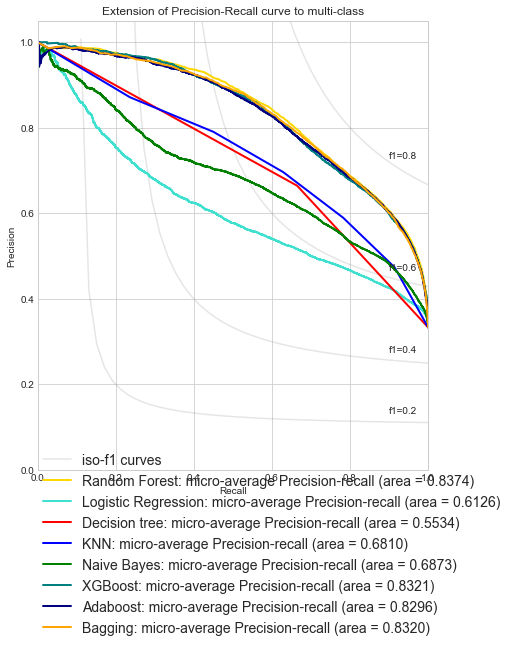

In [135]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')

l, = plt.plot(random[1], random[0], color='gold', lw=2)
lines.append(l)
labels.append('Random Forest: micro-average Precision-recall (area = {0:0.4f})'
              ''.format(random[2]))

l, = plt.plot(logis[1], logis[0], color='turquoise', lw=2)
lines.append(l)
labels.append('Logistic Regression: micro-average Precision-recall (area = {0:0.4f})'
              ''.format(logis[2]))

l, = plt.plot(decision[1], decision[0], color='red', lw=2)
lines.append(l)
labels.append('Decision tree: micro-average Precision-recall (area = {0:0.4f})'
              ''.format(decision[2]))

l, = plt.plot(knn[1], knn[0], color='blue', lw=2)
lines.append(l)
labels.append('KNN: micro-average Precision-recall (area = {0:0.4f})'
              ''.format(knn[2]))

l, = plt.plot(naive[1], naive[0], color='green', lw=2)
lines.append(l)
labels.append('Naive Bayes: micro-average Precision-recall (area = {0:0.4f})'
              ''.format(naive[2]))

l, = plt.plot(xgboost[1], xgboost[0], color='teal', lw=2)
lines.append(l)
labels.append('XGBoost: micro-average Precision-recall (area = {0:0.4f})'
              ''.format(xgboost[2]))

l, = plt.plot(ada[1], ada[0], color='navy', lw=2)
lines.append(l)
labels.append('Adaboost: micro-average Precision-recall (area = {0:0.4f})'
              ''.format(ada[2]))

l, = plt.plot(bag[1], bag[0], color='orange', lw=2)
lines.append(l)
labels.append('Bagging: micro-average Precision-recall (area = {0:0.4f})'
              ''.format(bag[2]))


fig = plt.gcf()
fig.subplots_adjust(bottom=0.1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()


In [139]:
# Run classifier
classifier_random = OneVsRestClassifier(RFC(n_estimators=300, n_jobs = 1,  random_state=random_state ,class_weight='balanced'))
classifier_random.fit(X_train, y_train)
y_score_random = classifier.predict_proba(X_test)

In [141]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score_random[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score_random[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score_random.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score_random,
                                                     average="micro")

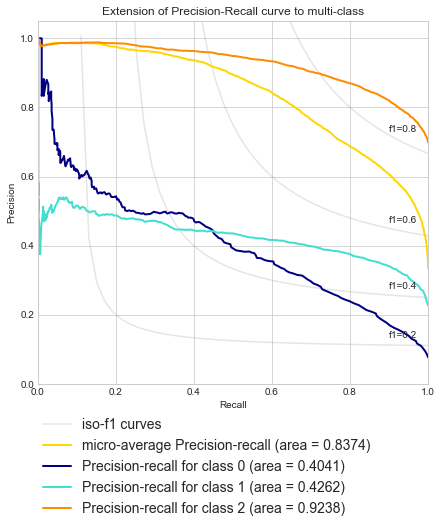

In [142]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.4f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.4f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()
